# CIFAR10 CNN, BatchNorm and Residual Networks
Adapted from PyTorch tutorial from (skipping details): https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Also, Prof. Inouye added batchnorm and residual network demos.

## Load data (skipping details see tutorial for details)

Files already downloaded and verified
Files already downloaded and verified


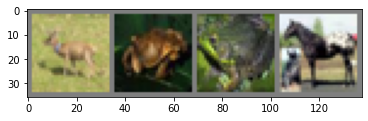

 deer  frog  frog horse


In [19]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define a Convolutional Neural Network


In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # nn.Conv2d(in_channels, out_channels/n_filters, kernel_size)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # nn.MaxPool2d(kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # nn.Linear(in_features, out_features)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Input is (N, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))  # (N, 6, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))  # (N, 16, 5, 5)
        x = x.view(-1, 16 * 5 * 5) # (N, 400)
        x = F.relu(self.fc1(x))  # (N, 120)
        x = F.relu(self.fc2(x))  # (N, 84)
        x = self.fc3(x)  # (N, 10)
        return x

net = Net()

## `torch.nn.Conv2d` and similar functions produce object that automatically registers its parameters inside the `torch.nn.Module`
## Thus, when calling `model.parameters()`, it will include these parameters
## Note that simple ReLU and maxpool functions do not have parameters

In [21]:
# Remember convolution weight has size (out_channels, in_channels, *kernel_size)
for name, p in net.named_parameters():
    print(name, ',', p.size(), type(p))
    #print(type(p))
    #print(p)

conv1.weight , torch.Size([6, 3, 5, 5]) <class 'torch.nn.parameter.Parameter'>
conv1.bias , torch.Size([6]) <class 'torch.nn.parameter.Parameter'>
conv2.weight , torch.Size([16, 6, 5, 5]) <class 'torch.nn.parameter.Parameter'>
conv2.bias , torch.Size([16]) <class 'torch.nn.parameter.Parameter'>
fc1.weight , torch.Size([120, 400]) <class 'torch.nn.parameter.Parameter'>
fc1.bias , torch.Size([120]) <class 'torch.nn.parameter.Parameter'>
fc2.weight , torch.Size([84, 120]) <class 'torch.nn.parameter.Parameter'>
fc2.bias , torch.Size([84]) <class 'torch.nn.parameter.Parameter'>
fc3.weight , torch.Size([10, 84]) <class 'torch.nn.parameter.Parameter'>
fc3.bias , torch.Size([10]) <class 'torch.nn.parameter.Parameter'>


# Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [23]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.155
[1,  4000] loss: 1.809
[1,  6000] loss: 1.645
[1,  8000] loss: 1.561
[1, 10000] loss: 1.523
[1, 12000] loss: 1.451
[2,  2000] loss: 1.373
[2,  4000] loss: 1.353
[2,  6000] loss: 1.325
[2,  8000] loss: 1.314
[2, 10000] loss: 1.274
[2, 12000] loss: 1.252
Finished Training


Let's quickly save our trained model:



In [29]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

# Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



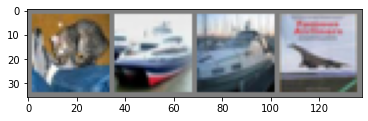

GroundTruth:    cat  ship  ship plane


In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [31]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [32]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [33]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   car truck plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 61 %
Accuracy of  bird : 37 %
Accuracy of   cat : 36 %
Accuracy of  deer : 41 %
Accuracy of   dog : 46 %
Accuracy of  frog : 77 %
Accuracy of horse : 65 %
Accuracy of  ship : 57 %
Accuracy of truck : 80 %


# Demo of batchnorm
(Batch normalization and residual networks content added by David Inouye)


In [36]:
# Demo of batchnorm 
import torch
import torch.nn as nn
class BatchNormModel(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(n_channels)
    
    def forward(self, x):
        x = self.bn(x)
        return x
    


### First let's create and inspect a batchnorm 2D (i.e., for images) layer

In [37]:
n_channels = 3 # Each channel is treated as a "feature" for images
bn_model = nn.BatchNorm2d(n_channels)
list(bn_model.named_parameters())

[('weight', Parameter containing:
  tensor([1., 1., 1.], requires_grad=True)), ('bias', Parameter containing:
  tensor([0., 0., 0.], requires_grad=True))]

Notice that there are weight and bias parameters for each channel.

### Let's investigate the layer's behavior during training

In [38]:
def print_mean_std(A, label='unlabeled'):
    print(f'{label}: Mean and standard deviation across channels')
    print(torch.mean(A, dim=(0,2,3))) # Sum 
    print(torch.std(A, dim=(0,2,3), unbiased=False))
    print()

torch.manual_seed(0)
bn_model.train()
batch1 = 2*torch.randn((100, n_channels, 2, 2)) + torch.arange(n_channels).reshape(1,n_channels,1,1) # (N, C, H, W)
batch2 = 3*torch.randn((100, n_channels, 2, 2)) + -5 # (N, C, H, W)
out1 = bn_model(batch1)
out2 = bn_model(batch2)
    
print_mean_std(batch1, 'batch1')
print_mean_std(out1, 'out1')
print_mean_std(batch2, 'batch2')
print_mean_std(out2, 'out2')

batch1: Mean and standard deviation across channels
tensor([0.0107, 1.0870, 2.0128])
tensor([2.0200, 1.9704, 2.1094])

out1: Mean and standard deviation across channels
tensor([ 8.0466e-09, -1.2368e-08, -2.0564e-08], grad_fn=<MeanBackward1>)
tensor([1.0000, 1.0000, 1.0000], grad_fn=<StdBackward0>)

batch2: Mean and standard deviation across channels
tensor([-4.9791, -5.2417, -4.8956])
tensor([3.0027, 3.0281, 2.9813])

out2: Mean and standard deviation across channels
tensor([ 5.3346e-08,  1.0118e-07, -4.6939e-08], grad_fn=<MeanBackward1>)
tensor([1.0000, 1.0000, 1.0000], grad_fn=<StdBackward0>)



Notice that even though distributions of the batches are quite different and different across channels, the output has been renormalized across the channel to always have zero mean and unit variance.

### What about during test time?
Let's set simulate two simple batches and then apply at test time

In [39]:
torch.manual_seed(0)
batch1 = torch.randn((100, n_channels, 2, 2)) + torch.arange(n_channels).reshape(1,n_channels,1,1) # (N, C, H, W)
batch2 = torch.randn((100, n_channels, 2, 2)) + 5 # (N, C, H, W)

bn_model.train()
out1 = bn_model(batch1)
out2 = bn_model(batch2)

bn_model.eval()  # Turn OFF dynamic normalization
print('Running mean and standard devaiation')
print(bn_model.running_mean)
print(torch.sqrt(bn_model.running_var))
print()

out1 = bn_model(batch1)
out2 = bn_model(batch2)
print_mean_std(batch1, 'batch1')
print_mean_std(out1, 'out1')
print_mean_std(batch2, 'batch2')
print_mean_std(out2, 'out2')

Running mean and standard devaiation
tensor([0.0987, 0.2405, 0.4342])
tensor([1.3707, 1.3690, 1.3793])

batch1: Mean and standard deviation across channels
tensor([0.0054, 1.0435, 2.0064])
tensor([1.0100, 0.9852, 1.0547])

out1: Mean and standard deviation across channels
tensor([-0.0681,  0.5865,  1.1398], grad_fn=<MeanBackward1>)
tensor([0.7368, 0.7197, 0.7647], grad_fn=<StdBackward0>)

batch2: Mean and standard deviation across channels
tensor([5.0070, 4.9194, 5.0348])
tensor([1.0009, 1.0094, 0.9938])

out2: Mean and standard deviation across channels
tensor([3.5808, 3.4178, 3.3355], grad_fn=<MeanBackward1>)
tensor([0.7302, 0.7373, 0.7205], grad_fn=<StdBackward0>)



Notice that the running mean and running standard deviation are used for normalization during test time rather than the batch.
Thus, it is important to set `model.eval()` or `model.train()` when running models with BatchNorm or other specialized layers.  Generally, it is just good practice to do this no matter what during training and testing.

### Very simple residual network in PyTorch
(See https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278 for a tutorial on the real ResNet architectures from https://arxiv.org/abs/1512.03385)

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualNet(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels, out_channels/n_filters, kernel_size)
        self.conv1 = nn.Conv2d(3, 16, 5)
        # nn.MaxPool2d(kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5, padding=2)
        # nn.Linear(in_features, out_features)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        # Input is (N, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))  # (N, 16, 14, 14)
        x = self.pool(F.relu(self.conv2(x)) + x)  # (N, 16, 7, 7)
        x = x.view(-1, 16 * 7 * 7) # 
        x = F.relu(self.fc1(x))  # (N, 120)
        x = F.relu(self.fc2(x)) + x  # (N, 84)
        x = self.fc3(x)  # (N, 10)
        return x

net = ResidualNet()

Notice that we merely need to add x back in.  PyTorch autograd takes care of the rest. (The real resnets are a bit more complicated but the basic idea is the same.)

### Let's train our very simple residual network

In [41]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the non-residual CNN on the 10000 test images: %d %%' % (53))
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  2000] loss: 1.824
[1,  4000] loss: 1.510
[1,  6000] loss: 1.394
[1,  8000] loss: 1.359
[1, 10000] loss: 1.282
[1, 12000] loss: 1.232
[2,  2000] loss: 1.151
[2,  4000] loss: 1.141
[2,  6000] loss: 1.094
[2,  8000] loss: 1.097
[2, 10000] loss: 1.080
[2, 12000] loss: 1.054
Finished Training
Accuracy of the non-residual CNN on the 10000 test images: 53 %
Accuracy of the network on the 10000 test images: 61 %


### (Content below is from original tutorial)

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


